In [1]:
from datasets import Dataset, load_dataset, features, ClassLabel, load_from_disk

import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
from itertools import chain

import networkx as nx
import community as community_louvain
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms import bipartite

import seaborn as sns
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

from llm_mri import LLM_MRI

/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregando os dados e dividindo classes

Top quantil: 6.0
Botton quantil: 4.0
All columns ['annotation id', 'original', 'auto', 'organization level', 'global score', 'label']
top: 97
botton: 81
TOTAL: 447


,text,label
0,Infarto agudo do miocárdio apresenta um perfil...,top
1,O infarto agudo do miocárdio (IAM) representa ...,top
2,"EQUIVALENTES ANGINOSOS: VOMITOS, SUDORESE, DOR...",mid
3,IAM é uma doença que afeta o músculo do coraçã...,mid
4,Infarto agudo do miocárdio é uma das principai...,mid


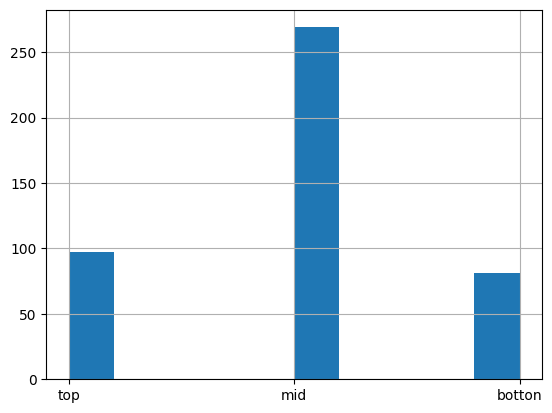

In [2]:
def label_answer(row, score, botton_quantile, top_quantile):
    if (row[score] < botton_quantile):
        return 'botton'
    elif (row[score] > top_quantile):
        return 'top'
    else:
        return 'mid'
        
exp = "_iam"
# exp = "_dpoc"
lang = "_pt"
# lang = "_en"
if "pt" in lang:
    text_column = 'original'
else:
    text_column = 'auto'
    
df_traducao = pd.read_csv('data/experimento_consolidado' + exp + '.csv')

score = 'global score'#organization_level,global_score
quantile = .3

print("Top quantil:", df_traducao[score].quantile(1 - quantile))
print("Botton quantil:", df_traducao[score].quantile(quantile))

#df_traducao[score].hist()

df_traducao['label'] = df_traducao.apply(
    label_answer,
    axis=1,
    score=score,
    botton_quantile=df_traducao[score].quantile(quantile),
    top_quantile=df_traducao[score].quantile(1 - quantile),
)

columns_to_remove = list(df_traducao.columns)
print("All columns", columns_to_remove)

columns_to_remove.remove(text_column)
columns_to_remove.remove('label')

df_data = df_traducao.rename(columns={text_column: 'text'}).drop(columns=columns_to_remove).reset_index(drop=True)


df_data['label'].hist()
# df_data = df_data.drop(df_data[df_data['label'] == "mid"].index).reset_index(drop=True)
print("top:", df_data['label'].loc[df_data['label'] == "top"].count())
print("botton:", df_data['label'].loc[df_data['label'] == "botton"].count())
print("TOTAL:", df_data['label'].count())
df_data.head()


# Passando os Dados para o Módulo

- converte o Dataframe para Dataset;
- carrega o modelo e os dados no módulo;
- processa as ativações;

In [3]:
subset = Dataset.from_pandas(df_data)
subset.cleanup_cache_files()

label_feature = subset.features['label']
class_names  = subset.unique("label")

class_feature = features.ClassLabel(names=sorted(class_names))
subset = subset.map(lambda str_value: {"label": class_feature.str2int(str_value)}, input_columns="label")

subset = subset.cast(features.Features({
    "label": class_feature,
    "text": subset.features["text"]}))

Casting the dataset: 100%|█████████| 447/447 [00:00<00:00, 152290.95 examples/s]


# Classe de métricas

In [4]:
class LLM_metrics:

    def __init__(self, Graph, label, model_name, map_dimensions, total_num_of_layers):
        self.Graph = Graph
        self.label = label
        self.model_name = model_name
        self.map_dimensions = map_dimensions
        self.layers = total_num_of_layers

        """
        Rotulando cada nó com a camada que ele pertence, isso é feito
        buscando o primeiro número do seu nome
        """
        for n in self.Graph.nodes:
            self.Graph.nodes[n]['layer'] = int(n.split('_')[0])
        
        self.projection_even, self.projection_odd = self.project_graph()

    def project_graph(self):
        nodes_even_layers = set()
        nodes_odd_layers = set()
        """
        Para fazer a projeção, é necessário que os nós tenham a label
        de qual camada pertencem.
        """
        for layer in range(self.layers + 1):
            if layer % 2 == 0:
                nodes_even_layers = nodes_even_layers.union({ n for n, d in self.Graph.nodes(data=True) if d['layer'] == layer})
            else:
                nodes_odd_layers = nodes_odd_layers.union({ n for n, d in self.Graph.nodes(data=True) if d['layer'] == layer})

        return bipartite.projected_graph(self.Graph, nodes_even_layers), bipartite.projected_graph(self.Graph, nodes_odd_layers)

    def get_degree_by_layer(self):
        camadas = []
        for x in range(self.layers + 1):
            camadas.append(str(x))
        df_layers = pd.DataFrame(columns=['layer', 'mean', 'var'])

        for i in camadas:
            df_layers = pd.concat([pd.DataFrame([[
                i,
                pd.Series([v for k, v in dict(nx.degree(self.Graph)).items() if k.split("_")[0] == i]).mean(),
                pd.Series([v for k, v in dict(nx.degree(self.Graph)).items() if k.split("_")[0] == i]).var(),
            ]], columns=df_layers.columns), df_layers], ignore_index=True)
        
        return df_layers.reindex(index=df_layers.index[::-1])

    def get_graph_center_of_mass(self):
        camadas = []
        for x in range(self.layers + 1):
            camadas.append(str(x))
        
        center_of_mass = 0

        for i in camadas:
            center_of_mass += ((pd.Series([k for k, v in dict(self.Graph.nodes()).items() if k.split("_")[0] == i]).count()) * (int(i) - (self.layers / 2)))
        
        return center_of_mass / len(list(self.Graph.nodes()))

    def get_graph(self):
        return self.Graph
    
    def get_basic_metrics(self):
        return {
            "mean_degree": pd.Series([v for k, v in dict(nx.degree(self.Graph)).items()]).mean(),
            "var_degree": pd.Series([v for k, v in dict(nx.degree(self.Graph)).items()]).var(),
            # "average_node_connectivity": nx.average_node_connectivity(self.Graph),
            "assortativity": nx.degree_assortativity_coefficient(self.Graph),
            "density": nx.density(self.Graph),
            "center_of_mass": self.get_graph_center_of_mass(),
            "model_name": self.model_name,
            "map_dimensions": self.map_dimensions,
            "label": self.label
        }

    def get_projection_metrics_even(self):
        return {
            "mean_degree": pd.Series([v for k, v in dict(nx.degree(self.projection_even)).items()]).mean(),
            "var_degree": pd.Series([v for k, v in dict(nx.degree(self.projection_even)).items()]).var(),
            "average_clustering": nx.average_clustering(self.projection_even),
            # "average_node_connectivity": nx.average_node_connectivity(self.projection_even),
            "assortativity": nx.degree_assortativity_coefficient(self.projection_even),
            "density": nx.density(self.projection_even),
            "model_name": self.model_name,
            "map_dimensions": self.map_dimensions,
            "label": self.label,
            "side": "even"
        }

    def get_projection_metrics_odd(self):
        return {
            "mean_degree": pd.Series([v for k, v in dict(nx.degree(self.projection_odd)).items()]).mean(),
            "var_degree": pd.Series([v for k, v in dict(nx.degree(self.projection_odd)).items()]).var(),
            "average_clustering": nx.average_clustering(self.projection_odd),
            # "average_node_connectivity": nx.average_node_connectivity(self.projection_odd),
            "assortativity": nx.degree_assortativity_coefficient(self.projection_odd),
            "density": nx.density(self.projection_odd),
            "model_name": self.model_name,
            "map_dimensions": self.map_dimensions,
            "label": self.label,
            "side": "odd"
        }

    def get_basic_metrics_list_of_names(self):
        return [
            'mean_degree',
             'var_degree',
             'average_clustering',
             # 'average_node_connectivity',
             'assortativity',
             'density',
             'model_name',
             'map_dimensions',
             'label',
             'side',
        ]

# Analisando Ativações do Grafo

In [5]:
# Já foram 10:[0,1,2,3,4]
# Já foram 20:[0,1,2]

models = { 
    # "nlpie/tiny-clinicalbert": 4,          
    # "distilbert-base-uncased": 6,
    # "google-bert/bert-base-uncased": 12,
    # "emilyalsentzer/Bio_ClinicalBERT": 12,
    # "google-bert/bert-large-uncased": 24,

    # "neuralmind/bert-base-portuguese-cased": 12, # 110M
    # "pucpr/biobertpt-all": 12, # 110M
    # "google-bert/bert-base-multilingual-cased": 12, # 110M
    # "neuralmind/bert-large-portuguese-cased": 24, # 330M
    
    # "openai-community/gpt2": 12,
    # "openai-community/gpt2-large": 36
    # "FacebookAI/xlm-roberta-large": 24,
    # "facebook/xlm-roberta-xl": 36,          # 3.48B

    
    "pierreguillou/gpt2-small-portuguese": 12, # 1.5B
    "pucpr/gpt2-bio-pt": 12, # 1.5B
}
position = 1
map_dimensions = [
    5,
    10,
    25
]
# number_of_layers = 1 + list(models.items())[position][1]

# df_basic = pd.DataFrame(columns = ['mean_degree','var_degree','average_node_connectivity','assortativity','density','center_of_mass','model_name','map_dimensions','label'])
# df_projection = pd.DataFrame(columns = ['mean_degree','var_degree','average_clustering','average_node_connectivity','assortativity','density','model_name','map_dimensions','label','side'])
# df_basic = pd.DataFrame(columns = ['mean_degree','var_degree','assortativity','density','center_of_mass','model_name','map_dimensions','label'])
# df_projection = pd.DataFrame(columns = ['mean_degree','var_degree','average_clustering','assortativity','density','model_name','map_dimensions','label','side'])

df_basic = pd.read_csv('data/comparison_basic_metrics' + lang + exp + '.csv')
df_projection = pd.read_csv('data/comparison_projection_metrics' + lang + exp + '.csv')

for model_name, number_of_layers in models.items():
    for dimension in map_dimensions:
        print("Loading:", model_name, " - ", dimension, " - ", number_of_layers)
        llm_mri = LLM_MRI(model=model_name, device="cpu", dataset=subset)
        llm_mri.process_activation_areas(map_dimension = dimension)
        
        print("Getting metrics")
        G_top = llm_mri.get_graph("top")
        G_botton = llm_mri.get_graph("botton")
        top_metrics = LLM_metrics(G_top, 'top', model_name.split('/')[-1], dimension, number_of_layers)
        botton_metrics = LLM_metrics(G_botton, 'botton',model_name.split('/')[-1], dimension, number_of_layers)

        print("Saving basic")
        df_basic = pd.concat([pd.DataFrame.from_dict([
            top_metrics.get_basic_metrics(),
            botton_metrics.get_basic_metrics()
        ]), df_basic], ignore_index=True)
        
        df_basic.to_csv('data/comparison_basic_metrics_pt' + exp + '.csv', index=False)
        
        print("Saving projection")
        df_projection = pd.concat([pd.DataFrame.from_dict([
            top_metrics.get_projection_metrics_even(),
            top_metrics.get_projection_metrics_odd(),
            botton_metrics.get_projection_metrics_even(),
            botton_metrics.get_projection_metrics_odd()
        ]), df_projection], ignore_index=True)
        
        df_projection.to_csv('data/comparison_projection_metrics' + lang + exp + '.csv', index=False)

        
        

# llm_mri = LLM_MRI(model=list(models.items())[position][0], device="cpu", dataset=subset)

# llm_mri.process_activation_areas(map_dimension = map_dimension)

# G_top = llm_mri.get_graph("top")
# G_botton = llm_mri.get_graph("botton")

# img = llm_mri.get_graph_image(G_botton)
# plt.box(False)
# plt.show()

# top_metrics = LLM_metrics(G_top, 'top', list(models.items())[position][0].split('/')[-1], map_dimension, number_of_layers)
# botton_metrics = LLM_metrics(G_botton, 'botton', list(models.items())[position][0].split('/')[-1], map_dimension, number_of_layers)

# print("Exemplo de métricas:", top_metrics.get_basic_metrics())




# sns.lineplot(data=top_metrics.get_degree_by_layer(), x='layer', y='mean', label="Top")
# sns.lineplot(data=botton_metrics.get_degree_by_layer(), x='layer', y='mean', label="Botton")

# pd.DataFrame.from_dict([
#     top_metrics.get_projection_metrics_even(),
#     botton_metrics.get_projection_metrics_even()
# ])

Loading: pierreguillou/gpt2-small-portuguese  -  5  -  12


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|█████████████████████████████| 447/447 [16:01<00:00,  2.15s/ examples]


Getting metrics
Saving basic
Saving projection
Loading: pierreguillou/gpt2-small-portuguese  -  10  -  12


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|█████████████████████████████| 447/447 [16:11<00:00,  2.17s/ examples]


Getting metrics
Saving basic
Saving projection
Loading: pierreguillou/gpt2-small-portuguese  -  25  -  12


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|█████████████████████████████| 447/447 [15:11<00:00,  2.04s/ examples]


Getting metrics
Saving basic
Saving projection
Loading: pucpr/gpt2-bio-pt  -  5  -  12


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|█████████████████████████████| 447/447 [16:40<00:00,  2.24s/ examples]


Getting metrics
Saving basic
Saving projection
Loading: pucpr/gpt2-bio-pt  -  10  -  12


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|█████████████████████████████| 447/447 [16:33<00:00,  2.22s/ examples]


Getting metrics
Saving basic
Saving projection
Loading: pucpr/gpt2-bio-pt  -  25  -  12


/home/figenio/Projetos/data_science/experimentacao/graph_experimenting/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|█████████████████████████████| 447/447 [17:29<00:00,  2.35s/ examples]


Getting metrics
Saving basic
Saving projection


In [6]:
# from transformers import AutoTokenizer, AutoModel

# import warnings
# warnings.filterwarnings('ignore')

# models = [ 
#     # "nlpie/tiny-clinicalbert",          
#     # "distilbert-base-uncased",
#     # "google-bert/bert-base-uncased",
#     # "emilyalsentzer/Bio_ClinicalBERT",
#     # "google-bert/bert-large-uncased",
    
#     # "openai-community/gpt2":,
#     # "openai-community/gpt2-large",
#     "FacebookAI/xlm-roberta-large",
#     # "facebook/xlm-roberta-xl",

#     "neuralmind/bert-base-portuguese-cased",
#     "neuralmind/bert-large-portuguese-cased",
#     "pucpr/biobertpt-all",
#     "google-bert/bert-base-multilingual-cased",
#     "pucpr/gpt2-bio-pt",
#     "pierreguillou/gpt2-small-portuguese",
# ]

# model = AutoModel.from_pretrained(models[6])

# model.config

In [7]:
# df_basic = pd.DataFrame(columns = ['mean_degree','var_degree','average_clustering','average_node_connectivity','assortativity','density','center_of_mass','model_name','map_dimensions','label'])


# df_basic


# camadas = []
# for x in range(12 + 1):
#     camadas.append(str(x))
        
# center_of_mass = 0

# for i in camadas:
#     print("Valor:", pd.Series([k for k, v in dict(G_top.nodes()).items() if k.split("_")[0] == i]).count())
#     print("Norm:", (int(i) - (12 / 2)))
#     center_of_mass += (pd.Series([k for k, v in dict(G_top.nodes()).items() if k.split("_")[0] == i]).count() * (int(i) - (12 / 2)))
#     print("Cent:", center_of_mass)

# center_of_mass / len(list(G_top.nodes()))

# [k for k in dict(G_top.nodes()).items() if k.startswith('1')]

# [n for n, d in G_top.nodes(data=True) if d['layer'] == 10]

# for n in G_top.nodes:
#     G_top.nodes[n]['layer'] = int(n.split('_')[0])

# [k for k,v in dict(nx.degree(G_top)).items() if k.split("_")[0] == '0']

In [8]:
# RODA NO PRIMEIRO MODELO

# pd.DataFrame.from_dict([
#     top_metrics.get_basic_metrics(),
#     botton_metrics.get_basic_metrics()
# ]).to_csv('data/comparison_basic_metrics.csv', index=False)

# pd.DataFrame.from_dict([
#     top_metrics.get_projection_metrics_even(),
#     top_metrics.get_projection_metrics_odd(),
#     botton_metrics.get_projection_metrics_even(),
#     botton_metrics.get_projection_metrics_odd()
# ]).to_csv('data/comparison_projection_metrics.csv', index=False)

# RODA PROS MODELOS SEGUINTES

# df_basic = pd.read_csv('data/comparison_basic_metrics.csv')
# df_projection = pd.read_csv('data/comparison_projection_metrics.csv')

# df_basic = pd.concat([pd.DataFrame.from_dict([
#     top_metrics.get_basic_metrics(),
#     botton_metrics.get_basic_metrics()
# ]), df_basic], ignore_index=True).to_csv('data/comparison_basic_metrics.csv', index=False)

# df_projection = pd.concat([pd.DataFrame.from_dict([
#     top_metrics.get_projection_metrics_even(),
#     top_metrics.get_projection_metrics_odd(),
#     botton_metrics.get_projection_metrics_even(),
#     botton_metrics.get_projection_metrics_odd()
# ]), df_projection], ignore_index=True).to_csv('data/comparison_projection_metrics.csv', index=False)

# print("rodou")

In [9]:
# Código que remove duplicatas

# df_basic = pd.read_csv('data/comparison_basic_metrics.csv')
# df_projection = pd.read_csv('data/comparison_projection_metrics.csv')

# df_basic = df_basic.iloc[2:]
# df_projection = df_projection.iloc[4:]

# df_projection = df_projection.drop(df_projection.index[[8,9]])

# df_basic.to_csv('data/comparison_basic_metrics.csv', index=False)
# df_projection.to_csv('data/comparison_projection_metrics.csv', index=False)

In [10]:
# top_metrics = []
# botton_metrics = []

# for G in G_tops:
    

# top_metrics = LLM_metrics(G_top, 'top', number_of_layers)
# botton_metrics = LLM_metrics(G_botton, 'botton', number_of_layers)

# # print("Exemplo de métricas:", top_metrics.get_basic_metrics())

# # sns.lineplot(data=top_metrics.get_degree_by_layer(), x='layer', y='mean', label="Top")
# # sns.lineplot(data=botton_metrics.get_degree_by_layer(), x='layer', y='mean', label="Botton")

# pd.DataFrame.from_dict([
#     top_metrics.get_projection_metrics_even(),
#     botton_metrics.get_projection_metrics_even()
# ])

In [11]:
# df_comparison = pd.DataFrame(columns=columns_base_metrics_names.append('label'))

# df_comparison = pd.concat([pd.DataFrame.from_dict([
#     top_metrics.get_projection_metrics_even(),
#     botton_metrics.get_projection_metrics_even()
# ]), df_comparison], ignore_index=True)

# df_comparison